# Building a Vision Transformer (ViT) from Scratch

In this tutorial, you'll implement each component of the Vision Transformer step by step. Each module is provided as a stub with descriptions to guide your implementation.

## Setup (Just run)

In [ ]:
# Colab Setup
try:
    import google.colab # type: ignore # noqa: F401

    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install -qqq jaxtyping sentence-transformers einops
    !git clone https://github.com/tom-pollak/nanoCLIP /content/nanoCLIP
    %cd /content/nanoCLIP
    %pip install -e .

except ImportError:
    IN_COLAB = False
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

# Imports and Testing
import sys
from pathlib import Path
from dataclasses import dataclass
import pytest
import torch as t
import torch.nn as nn
from torch import Tensor
import einops  # type: ignore # noqa: F401
from jaxtyping import Float
import functools
import nanoclip.vit as nanoclip_vit

project_root = Path("/content/nanoCLIP") if IN_COLAB else Path.cwd().resolve().parent

def replace_nanoclip_implementation(cls):
    @functools.wraps(cls)
    def wrapper(*args, **kwargs):
        return cls(*args, **kwargs)

    setattr(nanoclip_vit, cls.__name__, cls)
    return wrapper

def remove_test_module(module_name):
    modules_to_remove = [name for name in sys.modules if name.startswith(module_name)]
    for module_name in modules_to_remove:
        del sys.modules[module_name]


def run_test(test_name, test_func):
    remove_test_module("test_vit_clip")
    setattr(nanoclip_vit, test_func.__name__, test_func)
    pytest.main(["-v", "-p", "no:cacheprovider", "-s", f"{project_root}/tests/test_vit_clip.py::{test_name}"])


# Bit of a hack, ViTConfig doesn't seem to be able to be overwritted
def test_vit_config(vit_config_cls):
    config = vit_config_cls(
        n_layers=12,
        d_model=768,
        d_proj=512,
        image_res=(224, 224),
        patch_size=(16, 16),
        n_heads=12,
        norm_data=((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    )
    assert config.num_patches == (14, 14)
    assert config.seq_length == 197  # 14 * 14 + 1 (CLS token)
    assert config.d_head == 64  # 768 // 12
    print("Test passed!")

## 1. ViT Configuration

In [ ]:
@dataclass
class ViTConfig:
    n_layers: int
    d_model: int
    d_proj: int
    image_res: tuple[int, int]
    patch_size: tuple[int, int]
    n_heads: int
    norm_data: tuple[
        tuple[float, float, float], tuple[float, float, float]
    ]  # (mean, std)

    mlp_mult: int = 4
    causal_attn: bool = False

    # Calculated in __post_init__
    d_head: int = None  # type: ignore
    num_patches: tuple[int, int] = None  # type: ignore
    seq_length: int = None  # type: ignore

    def __post_init__(self):
        """
        Compute the attributes based on initial config:

        1. num_patches: Number of patches in based on the height & width and patch_size.
        2. seq_length: number_of_patches + the CLS token
        3. d_head: Dimension of each head. Use d_model & n_heads
        """
        raise NotImplementedError()

# run_test("test_vit_config", ViTConfig)
test_vit_config(ViTConfig)

## 2. Patch Embeddings

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, cfg: ViTConfig):
        super().__init__()
        self.cfg = cfg
        self.class_embedding = nn.Parameter(t.empty(cfg.d_model))
        self.patch_embedding = nn.Parameter(
            t.empty(cfg.d_model, 3 * cfg.patch_size[0] * cfg.patch_size[1])
        )
        self.position_embedding = nn.Parameter(t.empty(cfg.seq_length, cfg.d_model))

    def forward(
        self, pixel_values: Float[Tensor, "batch 3 height width"]
    ) -> Float[Tensor, "batch seq d_model"]:
        """
        Forward pass for PatchEmbeddings:
        1. Rearrange pixel_values into a sequence of patches:
          - Hint: Should be of shape (batch, num_patches, channels * patch_size)
        2. Project the patches with patch_embedding
        3. Add the class embedding
        4. Add the position embeddings
        """
        # Implementation steps here (refer to lines 70-96 in nanoclip/vit.py)
        raise NotImplementedError()

run_test("test_patch_embedding", PatchEmbedding)

## 3. Attention

ViTs use **full attention**, you _should not_ use a causal mask.

Many different ways of implementing attention -- I tend to like a very explicit einops operation.

#### Q: Why would this be the case

> Answer: We want each patch to fully attend to all other patches. The final output is the (first) CLS token.


In [ ]:
class Attention(nn.Module):
    def __init__(self, cfg: ViTConfig):
        """
        Initialize the Attention module:
        1. Create query, key, and value projection layers
        2. Create output projection layer
        """
        super().__init__()
        self.cfg = cfg
        self.q_proj = nn.Linear(cfg.d_model, cfg.d_model, bias=True)
        self.k_proj = nn.Linear(cfg.d_model, cfg.d_model, bias=True)
        self.v_proj = nn.Linear(cfg.d_model, cfg.d_model, bias=True)
        self.out_proj = nn.Linear(cfg.d_model, cfg.d_model, bias=True)

    def forward(
        self, x: Float[Tensor, "batch seq d_model"]
    ) -> Float[Tensor, "batch seq d_model"]:
        """
        Forward pass for Attention:
        1. Project input to query, key, and value
        2. Reshape q, k, v to separate the heads
        3. Compute (full) attention scores
        4. Apply softmax to get attention weights
        5. Apply attention weights to values
        6. Reshape and project to output
        """
        # (Solution: 109-141 nanoclip/vit.py)
        raise NotImplementedError()

run_test("test_attn", Attention)


## 4. MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, cfg: ViTConfig):
        """
        Initialize the MLP module:
        1. Create up-projection layer
        2. Create down-projection layer
        """
        super().__init__()
        self.cfg = cfg
        self.up_proj = nn.Linear(cfg.d_model, cfg.d_model * cfg.mlp_mult, bias=True)
        self.down_proj = nn.Linear(cfg.d_model * cfg.mlp_mult, cfg.d_model, bias=True)

    def forward(
        self, x: Float[Tensor, "batch seq d_model"]
    ) -> Float[Tensor, "batch seq d_model"]:
        """
        Forward pass for MLP:
        1. Apply up-projection
        2. Apply activation function (quick_gelu)
        3. Apply down-projection
        """
        # Implementation steps here (refer to lines 151-155 in nanoclip/vit.py)
        raise NotImplementedError()

run_test("test_mlp", MLP)

## 5. Transformer Block

Now we're putting it all together.

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg: ViTConfig):
        super().__init__()
        self.cfg = cfg
        self.attn = Attention(cfg)
        self.ln1 = nn.LayerNorm(cfg.d_model)
        self.mlp = MLP(cfg)
        self.ln2 = nn.LayerNorm(cfg.d_model)

    def forward(
        self, x: Float[Tensor, "batch seq d_model"]
    ) -> Float[Tensor, "batch seq d_model"]:
        """
        1. Apply layer norm -> attention to the input, add to residual
        2. Apply layer norm -> MLP, add to residual
        """
        # Implementation steps here (refer to lines 167-170 in nanoclip/vit.py)
        raise NotImplementedError()

run_test("test_xfmer_block", TransformerBlock)

## 6. Assembling the Vision Transformer (ViT) Model


In [ ]:
class ViT(nn.Module):
    def __init__(self, cfg: ViTConfig):
        super().__init__()
        self.cfg = cfg
        self.embed = PatchEmbedding(cfg)
        self.pre_ln = nn.LayerNorm(cfg.d_model)
        self.blocks = nn.ModuleList(
            [TransformerBlock(cfg) for _ in range(cfg.n_layers)]
        )
        self.post_ln = nn.LayerNorm(cfg.d_model)
        self.out_proj = nn.Linear(cfg.d_model, cfg.d_proj, bias=False)

    def forward(
        self, pixel_values: Float[Tensor, "batch 3 height width"]
    ) -> Float[Tensor, "batch d_proj"]:
        """
        1. Apply patch embeddings
        2. Apply pre-layer normalization
        3. Apply transformer blocks
        4. Select CLS token
        5. Apply post-layer normalization
        6. Apply output projection
        """
        # Implementation steps here (refer to lines 183-192 in nanoclip/vit.py)
        raise NotImplementedError()

run_test("test_e2e", ViT)


Congratulations! You've successfully implemented the Vision Transformer from scratch!

## Quick Demo

Seeing as we haven't implemented text encoders, we'll have to showcase an image-to-image task. He we'll UMAP the dog cats dataset to find any outliers.

Loading CLIP weights into our ViT

In [30]:
import torch as t
from nanoclip import ViT, ViTConfig # Comment this to use your own ViT
from nanoclip import build_preprocessor
from nanoclip.weights.clip import load_vit_weights
from huggingface_hub import hf_hub_download

cfg = ViTConfig(
    n_layers=12,
    d_model=768,
    d_proj=512,
    image_res=(224, 224),
    patch_size=(16, 16),
    n_heads=12,
    norm_data=(
        (0.48145466, 0.4578275, 0.40821073),
        (0.26862954, 0.26130258, 0.27577711),
    ),
    mlp_mult=4,
)

vit = ViT(cfg).eval()
sd_path = hf_hub_download("openai/clip-vit-base-patch16", "pytorch_model.bin")
sd = t.load(sd_path, map_location="cpu", weights_only=False)
load_vit_weights(vit, sd) # type: ignore

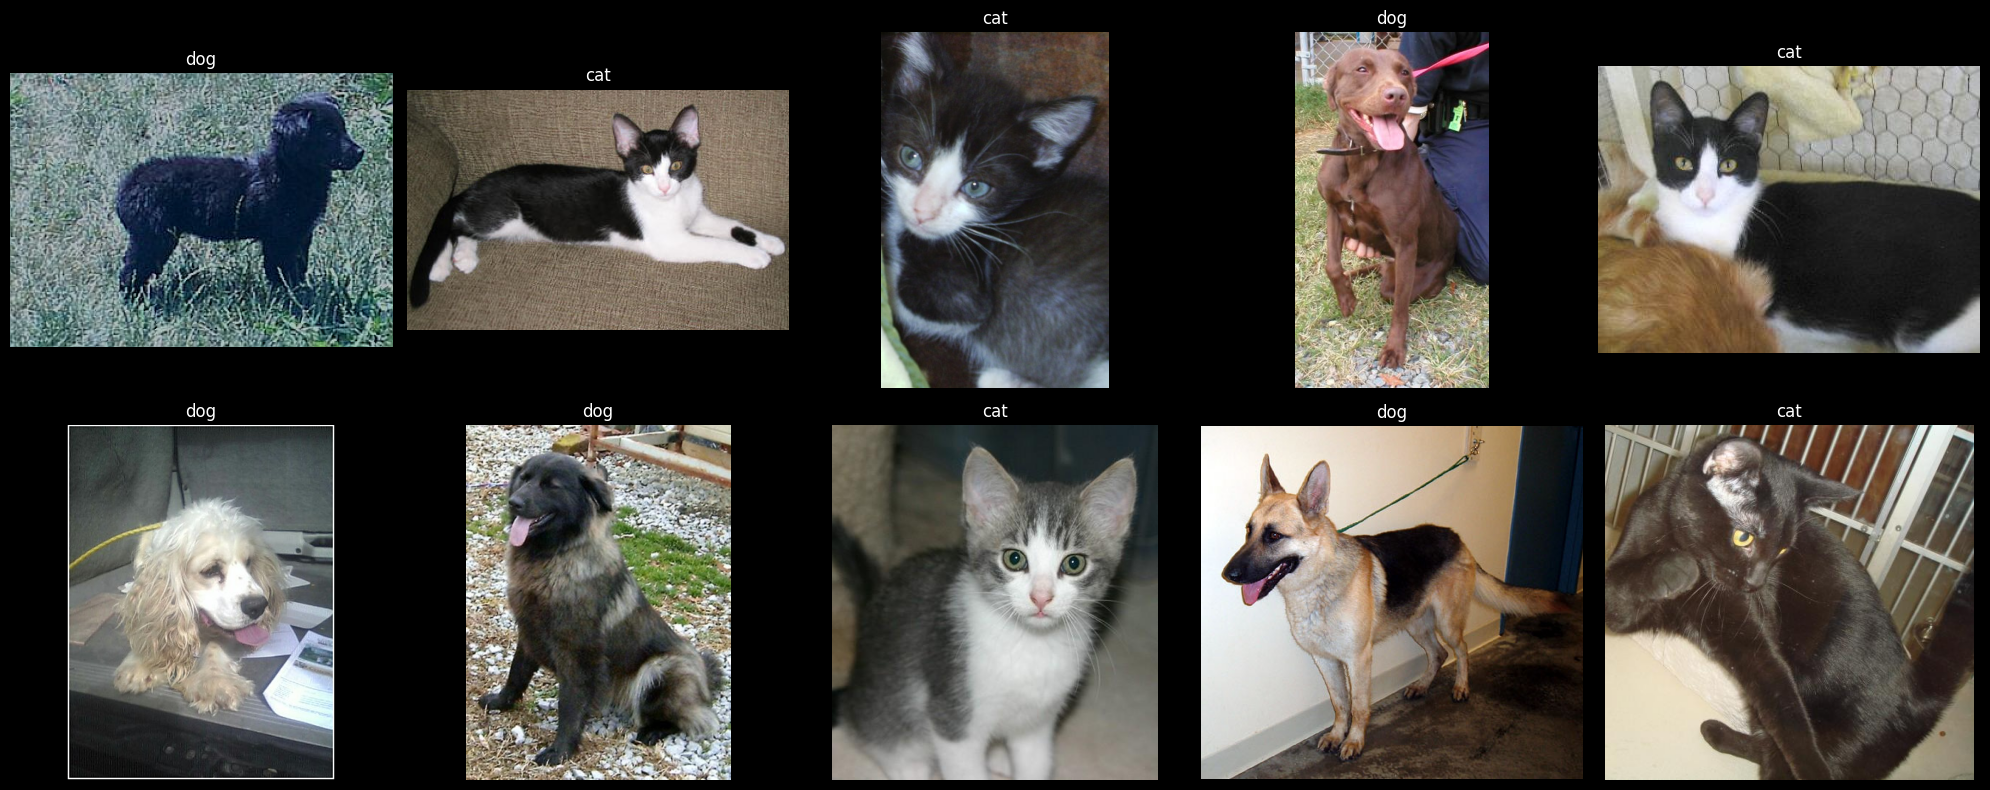

In [81]:
import matplotlib.pyplot as plt
from datasets import load_dataset

ds = load_dataset("microsoft/cats_vs_dogs", split="train").shuffle(seed=42).select(range(1000))
feats = ds.features
i2l = feats['labels'].int2str
l2i = feats['labels'].str2int


fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, item in enumerate(ds.select(range(10)).iter(1)):
    image = item['image'][0]
    label = item['labels'][0]

    # Display the image
    axes[i].imshow(image)
    axes[i].set_title(i2l(label))
    axes[i].axis('off')

plt.tight_layout()
plt.show()


15it [00:13,  1.10it/s]


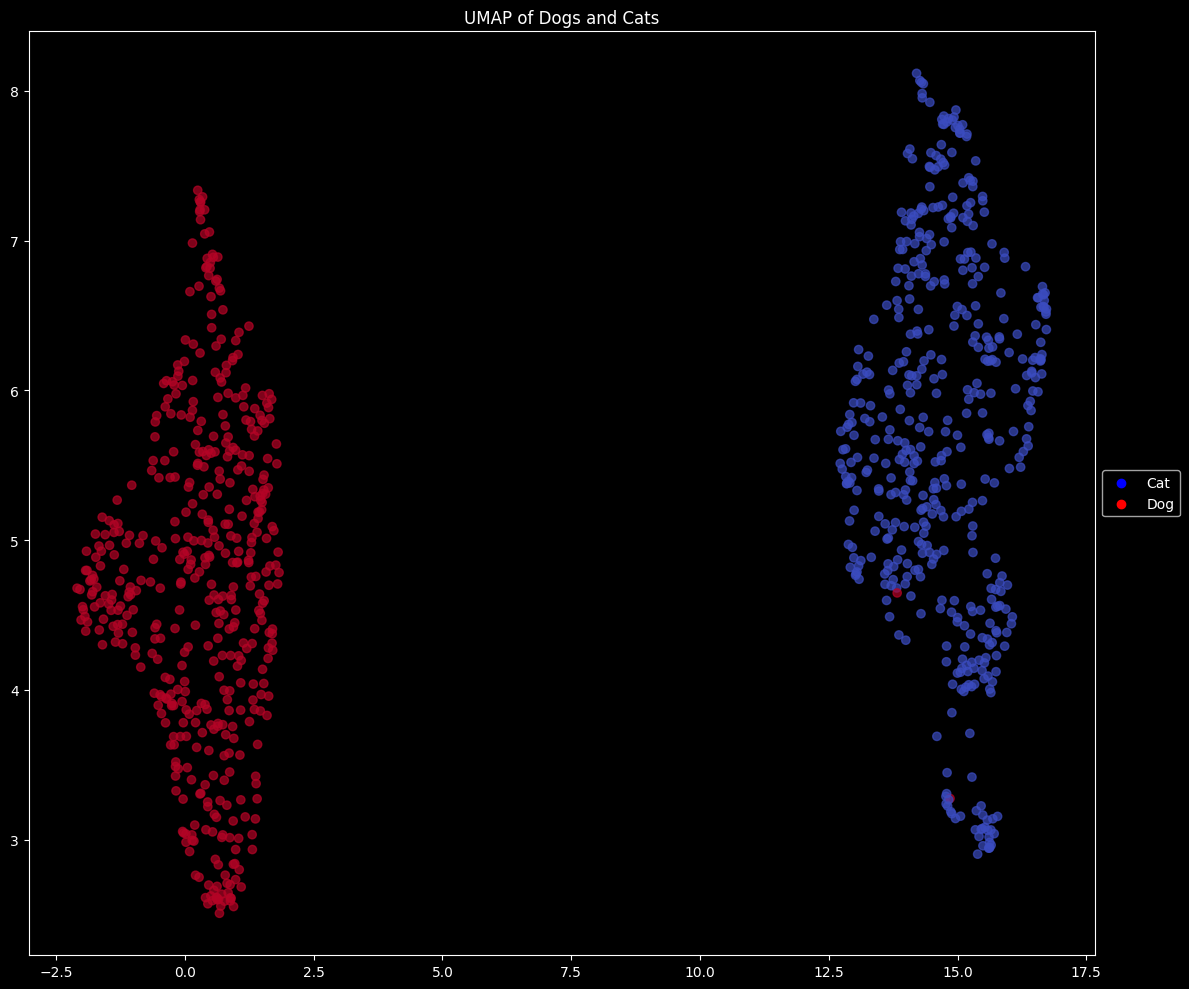

In [79]:
from tqdm import tqdm
import umap

preprocessor = build_preprocessor(cfg)
all_embeddings = []
all_labels = []
device = (
    "cuda"
    if t.cuda.is_available()
    else "mps"
    if t.backends.mps.is_available()
    else "cpu"
)

bs = 64
vit = vit.eval().to(device)
with t.no_grad():
    for batch in tqdm(ds.iter(bs, drop_last_batch=True)):
        images = [preprocessor(img) for img in batch["image"]]
        images_tensor = t.stack(images).to(device)
        embeddings = vit(images_tensor)
        all_embeddings.append(embeddings.cpu())
        all_labels.extend(batch["labels"])

all_embeddings = t.cat(all_embeddings, dim=0)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric="cosine")
embedding_2d = reducer.fit_transform(all_embeddings.numpy())

fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(
    embedding_2d[:, 0], embedding_2d[:, 1], c=all_labels, cmap="coolwarm", alpha=0.7
)
ax.set_title("UMAP of Dogs and Cats")
ax.legend(handles=[
    ax.scatter([], [], c='blue', label='Cat'),
    ax.scatter([], [], c='red', label='Dog')
], loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

Weird, two two cats in the dog cluster :thinking: let's investigate!

We can use KNN to find the neighbors of the dogs that are closest to cats


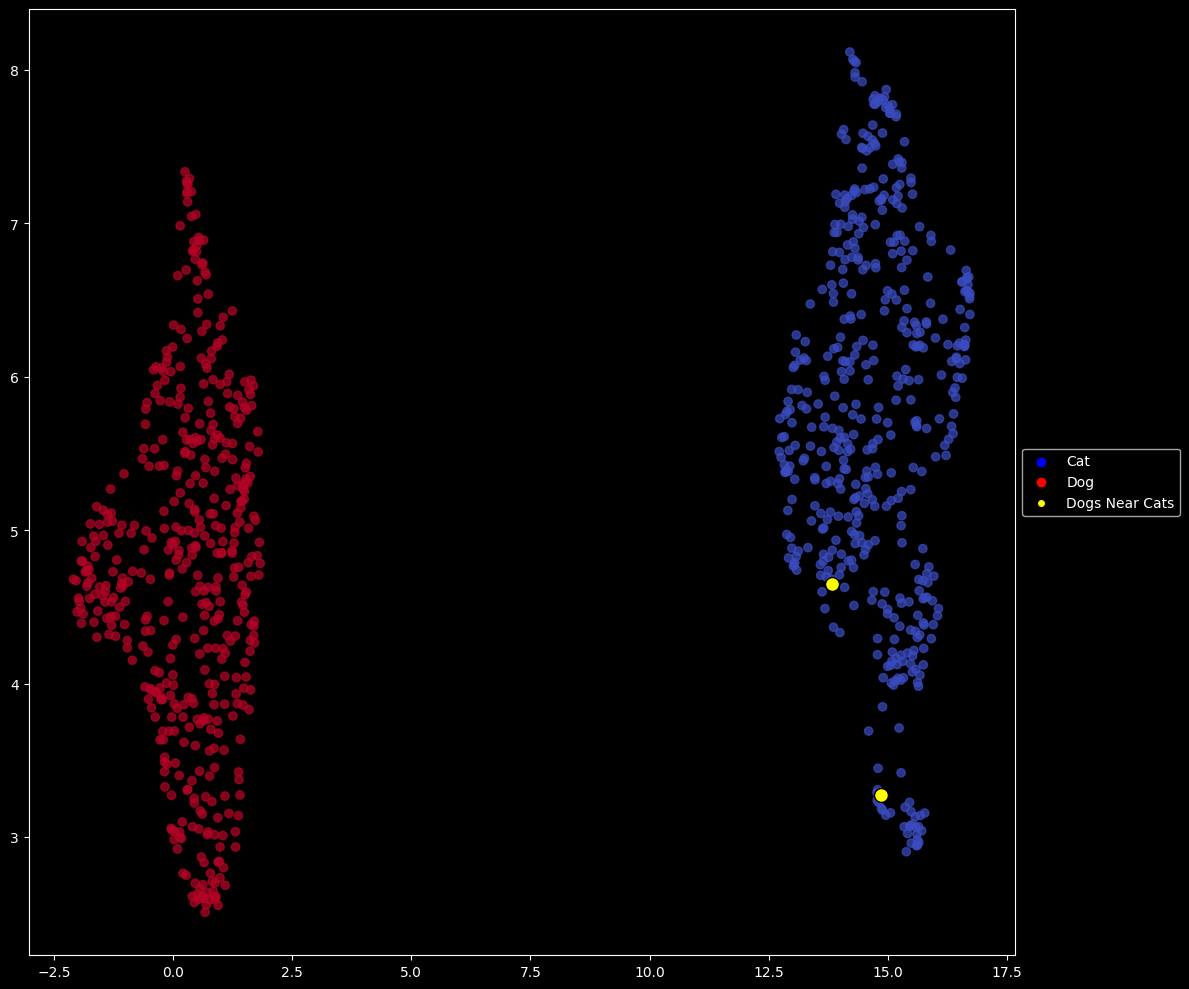

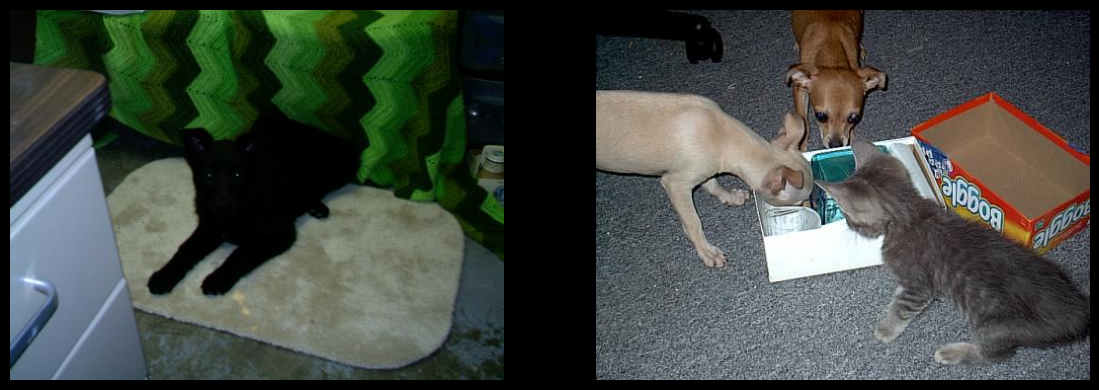

In [80]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

k = 5
knn = NearestNeighbors(n_neighbors=k).fit(embedding_2d)

dog_indices = np.where(np.array(all_labels) == l2i("dog"))[0]
dogs_with_cats_neighbors = [
    dog_idx for dog_idx in dog_indices
    if np.sum(np.array(all_labels)[knn.kneighbors([embedding_2d[dog_idx]])[1][0]] == l2i("cat")) > k // 2
]

## Plotting
fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=all_labels, cmap="coolwarm", alpha=0.7)
ax.scatter(
    embedding_2d[dogs_with_cats_neighbors, 0],
    embedding_2d[dogs_with_cats_neighbors, 1],
    color="yellow", label="Dogs Near Cats", s=100, edgecolors="black"
)
ax.legend(handles=[
    ax.scatter([], [], c='blue', label='Cat'),
    ax.scatter([], [], c='red', label='Dog'),
    ax.scatter([], [], c='yellow', edgecolors='black', label='Dogs Near Cats')
], loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

## Show the images

samples = ds[dogs_with_cats_neighbors]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.imshow(samples['image'][0])
ax2.imshow(samples['image'][1])

ax1.axis('off')
ax2.axis('off')

plt.tight_layout()
plt.show()